In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

%matplotlib inline

In [7]:
! ls data/

Data_Dictionary.xlsx          sample_submission.csv
historical_transactions.csv   test.csv
merchants.csv                 train.csv
new_merchant_transactions.csv


In [4]:
train_dtypes = {
    'feature_1' : np.int32,
    'feature_2' : np.int16,
    'feature_3' : np.int16,
    'target' : np.float64
}

test_dtypes = {
    'feature_1' : np.int16,
    'feature_2' : np.int16,
    'feature_3' : np.int16
}

merch_dtypes = {
    'merchant_group_id' : np.int32,
    'merchant_category_id' : np.int16,
    'subsector_id' : np.int16,
    'active_months_lag3' : np.int16,
    'active_months_lag6' : np.int16,
    'avg_sales_lag3' : np.float64,
    'avg_sales_lag6' : np.float64,
    'avg_sales_lag12' : np.float64,
    'active_months_lag12' : np.int16,
    'city_id' : np.int16,
    'state_id' : np.int16,
    'category_2' : np.float16
}

trans_dtypes = {
    'city_id': np.int16,
    'installments': np.int16,
    'merchant_category_id': np.int16,
    'month_lag': np.int16,
    'category_2': np.float64,
    'state_id': np.int16,
    'subsector_id': np.int16
}

In [5]:
train = pd.read_csv('data/train.csv', dtype=train_dtypes)
test = pd.read_csv('data/test.csv', dtype=test_dtypes)

In [6]:
merch = pd.read_csv('data/merchants.csv', dtype=merch_dtypes)
hist_trans = pd.read_csv('data/historical_transactions.csv', dtype=trans_dtypes)
new_trans = pd.read_csv('data/new_merchant_transactions.csv', dtype=trans_dtypes)

In [7]:
for cols in ['category_1', 'category_4', 'most_recent_purchases_range', 'most_recent_sales_range']:
    merch[cols] = merch[cols].astype('category')

In [8]:
def column_match(df1, df2):
    return df1.columns.intersection(df2.columns).values

In [7]:
print(train.shape)
print(test.shape)
print(merch.shape)
print(hist_trans.shape)
print(new_trans.shape)

(201917, 6)
(123623, 5)
(334696, 22)
(29112361, 14)
(1963031, 14)


I identified the desired data types using a combination of several common Pandas functions and attributes - `.head()`, `.dtypes`, and `.describe()` - to determine which would be appropriate. By changing the data types of the columns, it decreases the amount of memory required for the dataframe as it's being read in, which should help speed up other operations downstream in the modeling process.

### Graphical Exploration

In [59]:
train.isna().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [60]:
test.isna().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [9]:
missing_card_no = test.loc[test.first_active_month.isna()].card_id.values[0]

In [91]:
column_match(test, hist_trans)

array(['card_id'], dtype=object)

In [118]:
hist_trans.query('card_id == @missing_card_no').sort_values(by='purchase_date').\
               head(1).purchase_date

25672893    2017-03-09 01:34:22
Name: purchase_date, dtype: object

In [10]:
test.fillna('2017-03', inplace=True)

In [67]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790


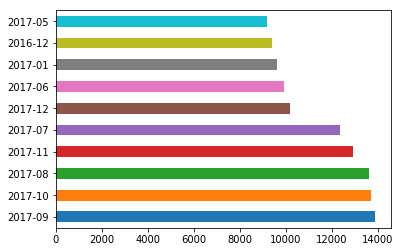

In [9]:
train.first_active_month.value_counts().head(10).plot(kind='barh')

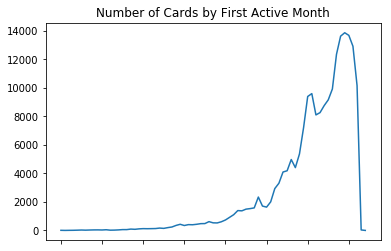

In [16]:
train.first_active_month.value_counts().sort_index().plot(title='Number of Cards by First Active Month')

In [54]:
train.first_active_month.min(), train.first_active_month.max()

('2011-11', '2018-02')

In [122]:
test.first_active_month.min(), test.first_active_month.max()

('2011-11', '2018-01')

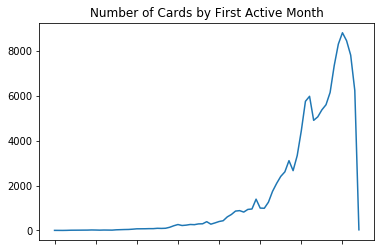

In [123]:
test.first_active_month.value_counts().sort_index().plot(title='Number of Cards by First Active Month')

In [92]:
train.card_id.nunique() == train.shape[0]

True

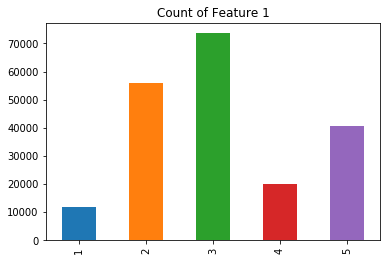

In [17]:
train.feature_1.value_counts().sort_index().plot(kind='bar', title='Count of Feature 1')

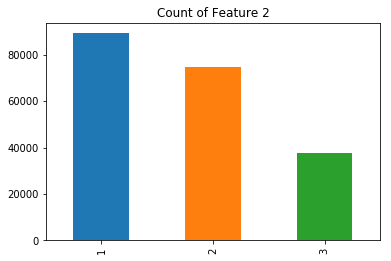

In [18]:
train.feature_2.value_counts().sort_index().plot(kind='bar', title='Count of Feature 2')

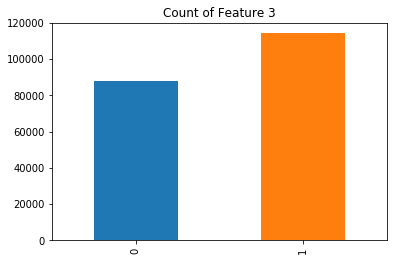

In [19]:
train.feature_3.value_counts().sort_index().plot(kind='bar', title='Count of Feature 3')

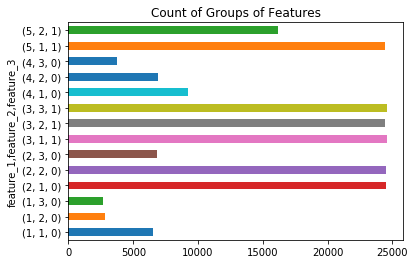

In [24]:
# better way to present this?
train.groupby(['feature_1', 'feature_2', 'feature_3']).target.count().plot(kind='barh',
                                                                          title='Count of Groups of Features')

While not the easiest to read, these are counts of each group of features taken together. We see six feature groupings - (2, 1, 0), (2, 2, 0), (3, 1, 1), (3, 2, 1), (3, 3, 1), and (5, 1, 1) - all show up around the maximum count of just below 25000. It's also notable that not every combination appears on the graph. Some, such as (1, 1, 1), do not appear in the plot and thus are not found in the training dataset. If these combinations show up in the test set, then our model could have some issues handling them and is something to keep an eye on down the road.  

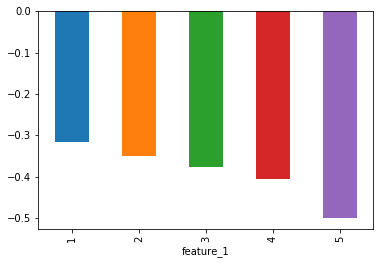

In [14]:
train.groupby('feature_1').target.mean().plot(kind='bar')

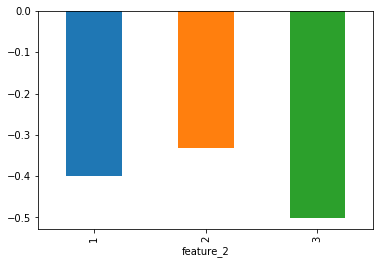

In [15]:
train.groupby('feature_2').target.mean().plot(kind='bar')

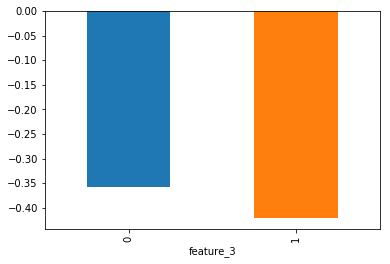

In [16]:
train.groupby('feature_3').target.mean().plot(kind='bar')

In [76]:
train.groupby(['feature_1', 'feature_2', 'feature_3']).groups.keys() == test.groupby(['feature_1', 'feature_2', 'feature_3']).groups.keys()

True

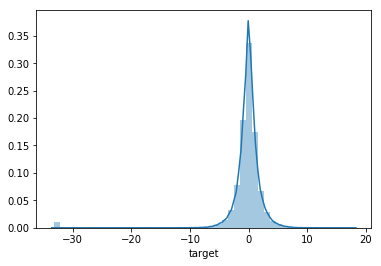

In [77]:
g = sns.distplot(train.target)

In [87]:
train.query('target > 10').shape[0]

48

In [78]:
train.query('target < -30').shape[0]

2207

I will need to investigate and handle these outlier target observations at some point.

(-6, 6)

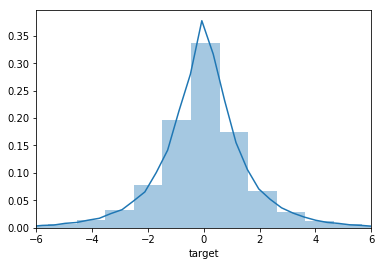

In [51]:
g = sns.distplot(train.target)
g.set_xlim(-6, 6)

In [ ]:
sns.lineplot(x=train.card_id, y=train.target)

In [52]:
train.target.mean()

-0.3936362990779874

**What do the values of the target mean?**

tbd

### EDA on Auxiliary Datasets

In [130]:
column_match(train, hist_trans)

array(['card_id'], dtype=object)

In [128]:
column_match(merch, hist_trans)

array(['merchant_id', 'merchant_category_id', 'subsector_id',
       'category_1', 'city_id', 'state_id', 'category_2'], dtype=object)

In [132]:
hist_trans.head(3).transpose()

,0,1,2
authorized_flag,Y,Y,Y
card_id,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc
city_id,88,88,88
category_1,N,N,N
installments,0,0,0
category_3,A,A,A
merchant_category_id,80,367,80
merchant_id,M_ID_e020e9b302,M_ID_86ec983688,M_ID_979ed661fc
month_lag,-8,-7,-6
purchase_amount,-0.703331,-0.733128,-0.720386


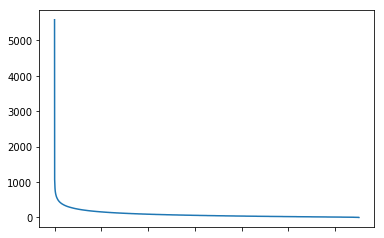

In [134]:
hist_trans.card_id.value_counts().plot()

In [148]:
hist_trans.card_id.nunique()

325540

In [18]:
trans_grp = hist_trans.groupby('card_id')

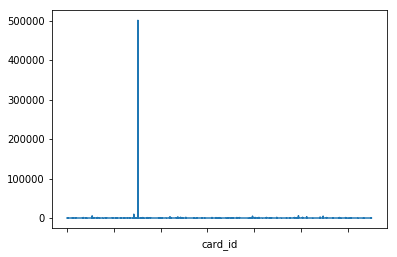

In [14]:
trans_grp.purchase_amount.mean().plot()

In [22]:
np.where(trans_grp.purchase_amount.mean() > 100000)

(array([75754]),)

In [28]:
trans_grp.purchase_amount.mean().loc[trans_grp.purchase_amount.mean() > 100000]

card_id
C_ID_3b6ac8e52d    500883.004724
Name: purchase_amount, dtype: float64

In [34]:
hist_trans.query('card_id == "C_ID_3b6ac8e52d"').purchase_amount.sum()

6010596.056687671

**TODO:**

- more eda on trans
- eda on merch data